In [7]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from sklearn.preprocessing import minmax_scale
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [8]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# --- Helper functions ---
def baseline_AsLS(y, lam=1e4, p=0.01, niter=10):
    L = len(y)
    D = np.diff(np.eye(L), 2)
    D = lam * D @ D.T
    w = np.ones(L)
    for _ in range(niter):
        b = np.linalg.solve(np.diag(w) + D, w * y)
        w = p * (y > b) + (1 - p) * (y < b)
    return b
def minmax_normalize(arr):
    mn, mx = arr.min(), arr.max()
    return (arr - mn) / (mx - mn) if mx > mn else np.zeros_like(arr)

# --- Preprocess with baseline + minmax norm ---
def preprocess(spectra):
    """
    spectra: 2D array shape (n_samples, n_wavenumbers)
    returns: same shape, baseline-corrected then minmax-normalized
    """
    out = np.zeros_like(spectra, dtype=float)
    for i, spec in enumerate(spectra):
        bkg  = baseline_AsLS(spec)
        corr = spec - bkg
        out[i] = minmax_normalize(corr)
    return out

def smooth(spec, K_smooth=3):
    kernel = np.ones(K_smooth) / K_smooth
    return np.convolve(spec, kernel, mode='same')

# --- Main pipeline ---
def identify_with_knn(query_df, ref_df_train, ref_df_test=None,
    crop_max=1700, lam=1e4, p=0.01, niter=10,
    K_smooth=3, N_peak=12, w_max=15,
    height=0.01, prominence=0.01,
    n_neighbors=3):

    wav_cols = query_df.columns[:-1]
    wavs = pd.to_numeric(wav_cols)
    keep_cols = wav_cols[wavs < crop_max]

    # build matrices
    R_raw = ref_df_train[keep_cols].values.astype(float)
    labels = ref_df_train['Label'].values
    classes = np.unique(labels)

    R = preprocess(R_raw)

    # Characteristic peaks
    CPs = {}
    for chem in classes:
        specs = R[labels == chem]
        counts = np.zeros(R.shape[1], int)
        for s in specs:
            pks, _ = find_peaks(smooth(s, K_smooth),
                                height=height, prominence=prominence)
            counts[pks] += 1
        cp_idxs = np.argsort(counts)[-N_peak:]
        CPs[chem] = sorted(cp_idxs)

    global_cp = sorted({i for idxs in CPs.values() for i in idxs})

    # Train features
    X = []
    y = []
    for chem in classes:
        for s in R[labels == chem]:
            vec = [np.max(s[max(0, i - w_max//2):i + w_max//2 + 1]) for i in global_cp]
            X.append(minmax_scale(vec))
            y.append(chem)
    X = np.array(X)
    y = np.array(y)

    knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric='cosine')
    knn.fit(X, y)

    # Optional test set
    test_results = None
    if ref_df_test is not None:
        R_test = preprocess(ref_df_test[keep_cols].values.astype(float))
        y_true_test = ref_df_test['Label'].values
        X_test = np.vstack([
            minmax_scale([np.max(s[max(0, i - w_max//2):i + w_max//2 + 1]) for i in global_cp])
            for s in R_test
        ])
        y_pred_test = knn.predict(X_test)
        y_pred2_test = knn.kneighbors(X_test, n_neighbors=2, return_distance=False)
        y_pred2_test = np.array([[y[idx] for idx in row] for row in y_pred2_test])
        test_results = (y_true_test, y_pred_test, y_pred2_test)

    # Validation set (query)
    Q_raw = query_df[keep_cols].values.astype(float)
    Q = preprocess(Q_raw)
    Q_feat = np.vstack([
        minmax_scale([np.max(s[max(0, i - w_max//2):i + w_max//2 + 1]) for i in global_cp])
        for s in Q
    ])
    pred1 = knn.predict(Q_feat)
    neigh_idx = knn.kneighbors(Q_feat, n_neighbors=2, return_distance=False)
    pred2 = np.array([[y[idx] for idx in row] for row in neigh_idx])

    return pred1, pred2, knn, CPs, test_results

[VALIDATION] Top-1 k-NN Acc: 100.00%
[VALIDATION] Top-2 k-NN Acc: 100.00%
[TEST] Top-1 k-NN Acc: 100.00%
[TEST] Top-2 k-NN Acc: 100.00%


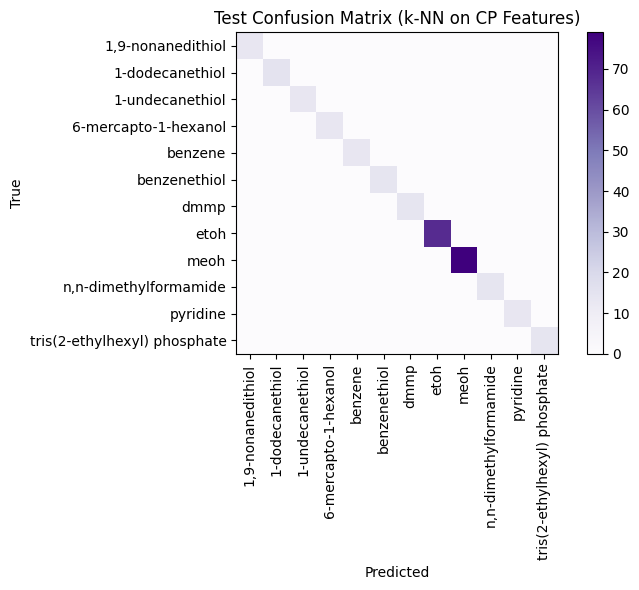

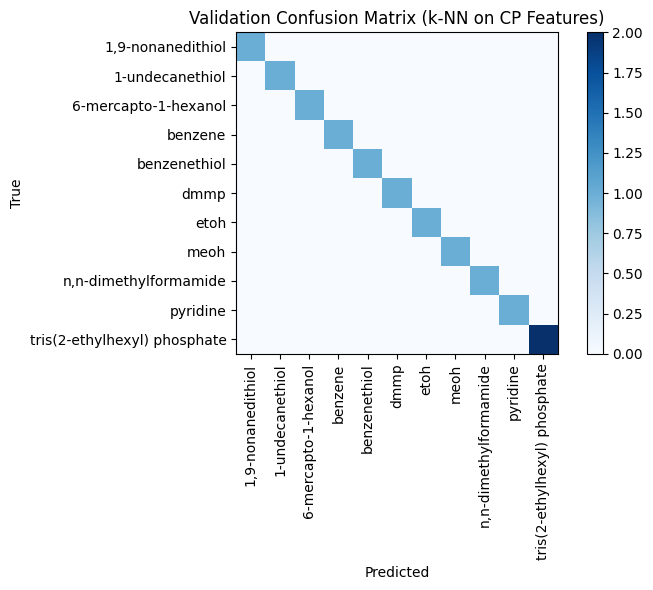

In [9]:
# --- Run and evaluate ---
ref_df = pd.read_csv('reference_Raman.csv')
query_df = pd.read_csv('query_Raman.csv')

# Split reference data 50/50
ref_train, ref_test = train_test_split(ref_df, test_size=0.5, stratify=ref_df['Label'], random_state=42)

# Run model
pred_val, pred_val_top2, knn_model, CPs, test_results = identify_with_knn(query_df, ref_train, ref_test)

# Validation accuracy
true_val = query_df['Label'].values
acc1_val = accuracy_score(true_val, pred_val)
acc2_val = np.mean([t in row for t, row in zip(true_val, pred_val_top2)])
print(f"[VALIDATION] Top-1 k-NN Acc: {acc1_val:.2%}")
print(f"[VALIDATION] Top-2 k-NN Acc: {acc2_val:.2%}")

# Test set accuracy
if test_results:
    true_test, pred_test, pred2_test = test_results
    acc1_test = accuracy_score(true_test, pred_test)
    acc2_test = np.mean([t in row for t, row in zip(true_test, pred2_test)])
    print(f"[TEST] Top-1 k-NN Acc: {acc1_test:.2%}")
    print(f"[TEST] Top-2 k-NN Acc: {acc2_test:.2%}")

    # Confusion matrix (test)
    labels_unique_test = np.unique(true_test)
    cm_test = confusion_matrix(true_test, pred_test, labels=labels_unique_test)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm_test, cmap='Purples', interpolation='nearest')
    plt.xticks(range(len(labels_unique_test)), labels_unique_test, rotation=90)
    plt.yticks(range(len(labels_unique_test)), labels_unique_test)
    plt.colorbar()
    plt.title("Test Confusion Matrix (k-NN on CP Features)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

# Confusion matrix (validation)
labels_unique = np.unique(true_val)
cm = confusion_matrix(true_val, pred_val, labels=labels_unique)
plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.xticks(range(len(labels_unique)), labels_unique, rotation=90)
plt.yticks(range(len(labels_unique)), labels_unique)
plt.colorbar()
plt.title("Validation Confusion Matrix (k-NN on CP Features)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()